In [77]:
%pip install numpy

Note: you may need to restart the kernel to use updated packages.


c:\Users\Lenovo\OneDrive - Universidad EAFIT\Documentos\Obsidian\Obsidian\2024-1\Cuántica\ps\notas\.venv\Scripts\python.exe: No module named pip


Tratando de implementar
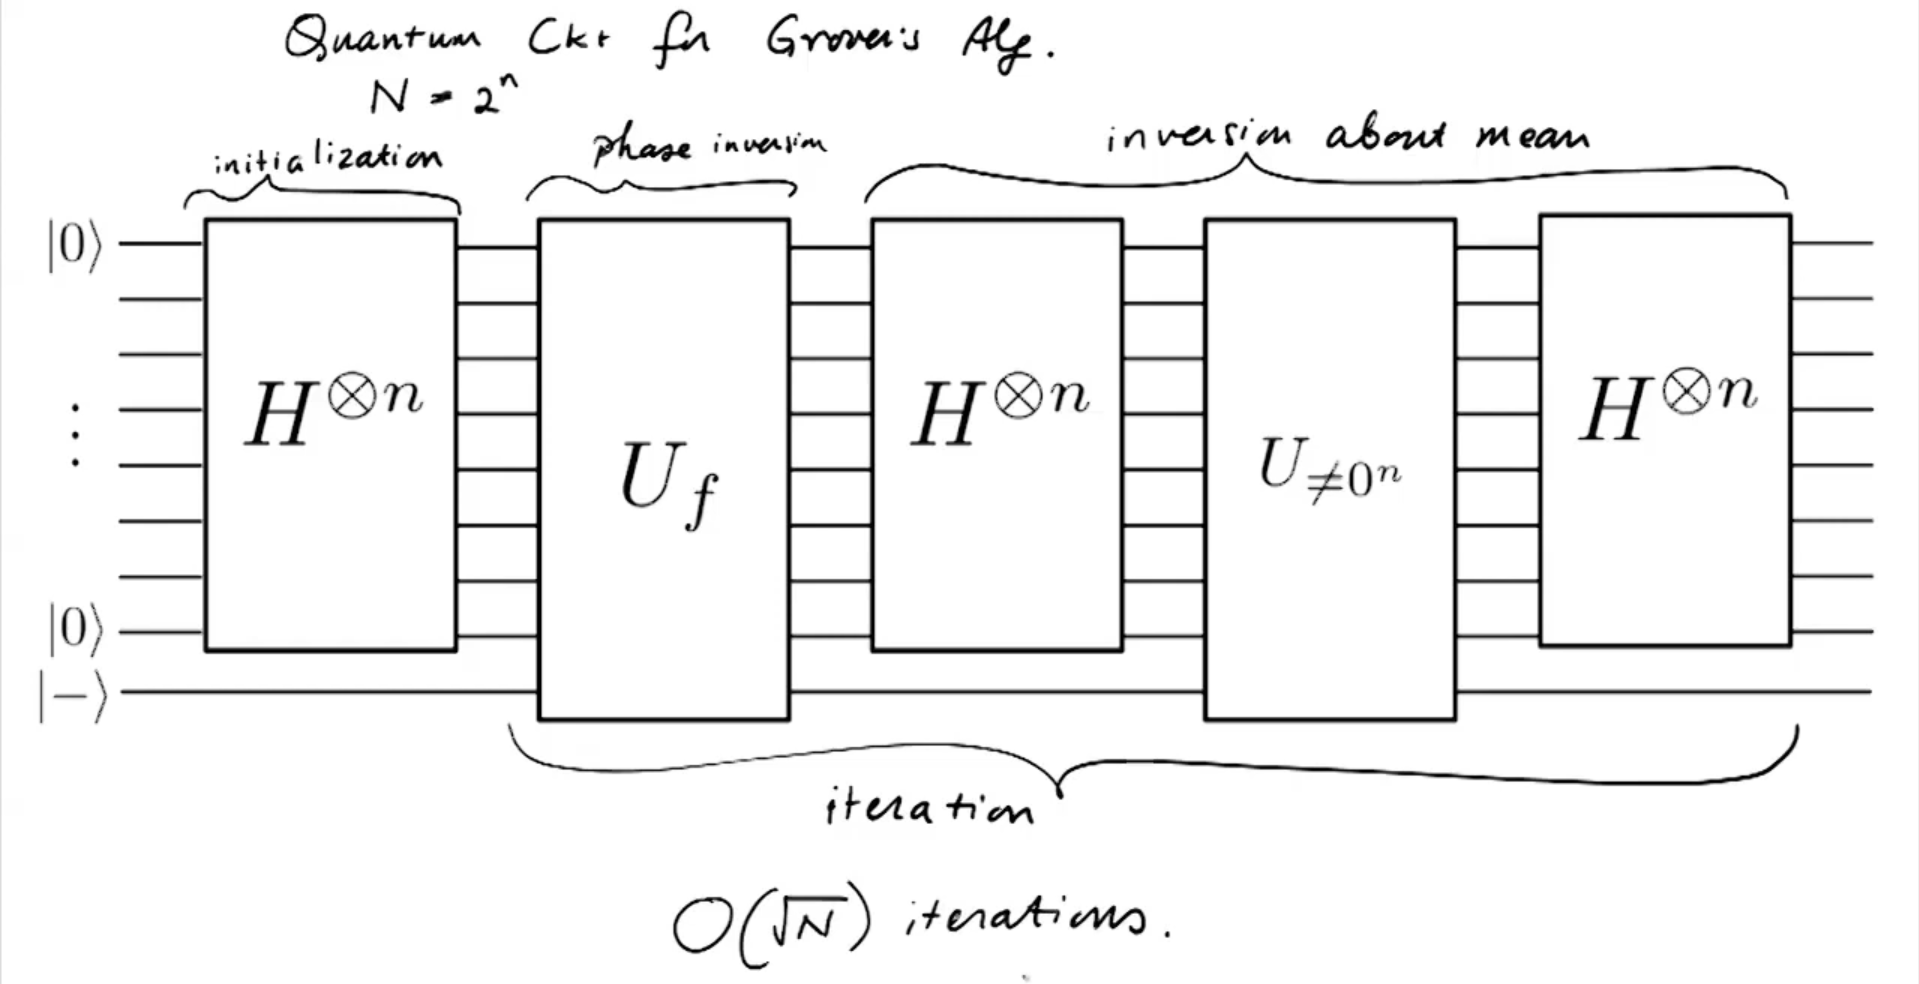

In [78]:
import numpy as np
from numpy import ndarray
from math import log, sqrt, ceil
from typing import Callable
from functools import lru_cache

In [79]:
def hadamard() -> ndarray:
  h = np.sqrt(0.5) * np.array([[1, 1], [1, -1]])
  return h

In [80]:

@lru_cache(maxsize=1)
def H_otimes_n(n: int) -> ndarray:
    r"""
    Retorna :math:`H^{\otimes n}`

    Args:
        n (int): numero de qubits
    """

    hadamard: ndarray = np.sqrt(0.5) * np.array([[1, 1], [1, -1]])
    result = hadamard
    n -= 1  # primera iteración siempre inicia en hadamard, pero no cuenta como multiplicación

    for _ in range(n):
        result = np.kron(result, hadamard)
    # Kronecker products crea submatrices, esto reshapea a matriz
    op = result.reshape(-1, result.shape[-1])
    return op


In [81]:
@lru_cache(maxsize=1)
def proyection_about_mean(N: int):
    op = np.ones(N) * (2 / N) - np.eye(N)
    return op


In [82]:
def op_deets(op: ndarray, label: str):
    print()
    print(label)
    print(op.shape)
    # print("norm:", np.linalg.norm(op, ord=np.inf))
    print(op)
    print()
    print()

In [83]:
@lru_cache(maxsize=1)
def phase_inversion(N, f: Callable) -> ndarray:
    """
    1s en la diagonal si f(x)=0
    -1 en la diagonal si f(x)=1

    Esta matriz debe ser más grande.
    si hay 3 qubits en el sistema,
    U_f va a trabajar con un qubit auxiliar extra de f(x)
    Entonces si hay n qubits, la matriz de esta función es de
    shape(2^{n+1},2^{n+1})?

    Args:
        N (int): El número de estados
        f (Callable): _description_

    Returns:
        ndarray: _description_
    """
    # Define data, row indices, and column indices for non-zero elements
    data = list(-1 if f(x) else 1 for x in range(N))

    # Create a sparse CSC matrix
    # A_f = sp.csc_matrix((data, (row_indices, col_indices)), shape=(N,N))
    # WHY CANT YOU BE NORMAL
    A_f = np.diag(data)
    #op_deets(A_f, "A_f")
    U_f = np.kron(np.eye(2),A_f)
    # Kronecker products crea submatrices, esto reshapea a matriz
    U_f: ndarray = U_f.reshape(-1, U_f.shape[-1])
    return U_f


In [84]:

def dag(A: ndarray):
    return np.conj(A.T)

def are_approximate(A, B) -> bool:
    """Are two matrices approximately equal with a tolerance

    Args:
        A (ndarray)
        B (ndarray):

    Returns:
        bool: true when the element-wise difference is lower than the tolerance threshold
    """
    tol = 1e-11  # Tolerance threshold
    # print(f"{tol:.11f}")
    # Element-wise absolute difference
    diff = np.abs(A - B)

    # Check if all elements are within tolerance (boolean mask)
    is_approx = np.all(diff <= tol)
    if is_approx:
        return True
    return False

def is_op_unitary(A, N):
    case1 = dag(A) @ A
    case2 = A @ dag(A)
    assert are_approximate(case1, case2) and are_approximate(case2, np.eye(N))

def is_v_unit(v:ndarray):
    print("v_2 inner product")
    v_2 = (v.T @ v)[0][0]
    tol = 1e-11
    print(v_2)
    is_approximate = tol > abs(v_2 - 1)
    assert is_approximate

def test_ops(n, N, f, psi):
    print(f"Qubits n: {n}, Estados totales N : {N}")
    H = H_otimes_n(n)
    is_op_unitary(H, N)
    # Hadamard además de unitaria, es Hermitian?
    assert are_approximate(H, dag(H))
    label = "Hadamard"
    op_deets(H, label)
    U_0n = proyection_about_mean(N)
    is_op_unitary(U_0n, N)
    label = "Proyection about mean:"
    op_deets(U_0n, label)
    # P_I es una función oráculo
    P_I = phase_inversion(N, f)
    is_op_unitary(P_I, N * 2)
    label = "Phase inversion:"
    op_deets(P_I, label)
    # psi es un vector unitario
    is_v_unit(psi)
    print("psi es unitario")


In [85]:
N = 5


def f(x: int) -> bool:
    """Función binaria de input a la función oráculo.
    Se supone que si la conozco pues medio ya se donde está lo que busco.

    A partir de esta función se genera la matriz U_f.

    Debe cumplir: f:{0,1}^n -> {0,1} por lo que hay 2^(2^N)
    versiones diferentes de f


    Args:
        x (int): estado del sistema cuantico que puede o no ser el buscado

    Returns:
        int: binario que dice si esto es el estado buscado o no
    """
    return (x) % 4 == 0

In [86]:
def grover(N: int, f: Callable, v: bool = False):
    """Función donde se implementa Grover's Algorithm

    Args:
        N (int): numero de estados
        f (Callable): función que toma estados y dice si son x* o no
        v (bool): Imprime pasos (y tests) intermedios
    """
    n = ceil(log(N, 2))  # Numero de qubits
    N = 2**n
    # Inicializacion

    psi = np.zeros((N,1))
    psi[0][0]=1
    #psi = np.ones(N) / np.sqrt(N)
    psi = H_otimes_n(n) @ psi

    # Hacer el auxiliar
    auxiliary = np.resize(hadamard() @ np.ones((2, 1)) * (1 / sqrt(N)), (N, 1))
    if v:
        test_ops(n, 2**n, f, psi)
        print("auxiliary:")
        print(auxiliary)

        print("psi_0:")
        print(psi)


    # sqrt(n) iteraciones o int(sqrt(N * np.pi / 4)) + 1 es el numero
    # óptimo de iteraciones para grover
    # for _ in range(int(sqrt(N * np.pi / 4)) + 1):
    for _ in range(int(sqrt(N)) + 1):
        # Phase Inversion

        psi_c = np.vstack((psi, auxiliary))
        psi_c = phase_inversion(N, f) @ psi_c
        if v:
            print("psi_i: post PI")
            print(psi)
        # Splitting based on original size
        psi = psi_c[:N, :]
        auxiliary = psi_c[N:, :]
        psi = np.resize(psi, (N, 1))
        if v:
            print("psi_i: post PI resize")
            print(psi)

        # Proyection about mean
        psi = H_otimes_n(n) @ psi
        psi = proyection_about_mean(N) @ psi
        psi = H_otimes_n(n) @ psi
    if v:
        print("psi:")
        print(psi)
    return psi


In [87]:
shots = 100
answers = []
psi = grover(N, f, False)
for _ in range(shots):
     assert are_approximate(psi, grover(N,f,False))
# Create a bitmask where True indicates a positive value
bitmask = psi > 0

# Filter the original array using boolean indexing and get the index as well
found = psi[bitmask], np.nonzero(bitmask)[0]

# Print the positive values/ found values
     
found
# TODO hacer phase inversion, como sparse matrix de ser posible
# TODO hacer el qubit auxiliar
# TODO hacer shots en esta vaina
# TODO print con LaTex?

(array([0.35355339]), array([4], dtype=int64))